In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt

plt.style.use('ggplot')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


In [3]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

from sklearn.linear_model import LogisticRegression

from joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one
from scipy import sparse

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
def balanced_positive(X, y):
    '''Устраняем дисбаланс в целевой переменной. Добавляет k раз позитивную часть датафрейма и перемешивает его'''
    X_ = X.copy()
    X_['target'] = y
    msk = X_['target'] == 1
    X_positive = X_.loc[msk, :]
    
    nmb_positive = X_positive.shape[0]
    nmb_negative = X_.shape[0] - nmb_positive
    
    k = nmb_negative // nmb_positive - 1
    n = nmb_negative % nmb_positive

    for k in range(k):
        X_ = pd.concat([X_, X_positive])
   
    sklearn.utils.shuffle(X_)
    y_ = X_.pop('target')
    return X_, y_

In [6]:
def divide_features(X, features_exclude, N_cat=15):
    X_nunique = X.apply(lambda x: x.nunique(dropna=False))
    features_all = set(X_nunique.index.tolist()) - set(features_exclude)

    features_const = set(X_nunique[X_nunique == 1].index.tolist()) - set(features_exclude)
    features_other = features_all - (features_const)

    features_categorical = set(X_nunique.loc[features_other][X_nunique.loc[features_other] <= N_cat].index.tolist())
    features_other = features_other - features_categorical

    features_numeric = (X.loc[:,features_other].fillna(0).astype(int).sum() - X.loc[:,features_other].fillna(0).sum()).abs()
    features_numeric = set(features_numeric[features_numeric > 0].index.tolist())
    features_other = features_other - features_numeric

    assert(X_nunique.shape[0] == len(features_const) + len(features_numeric) + len(features_categorical)) +len(features_exclude)
    return list(features_const), list(features_categorical), list(features_numeric)



In [7]:
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))

        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [8]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[[self.key]].rename(columns={self.key: 'cat/'+self.key})
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]].rename(columns={self.key: 'nmb/'+self.key})

class PolynomSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key, degree=2):
        self.key = key
        self.degree = degree
        self.column = 'pol'+str(degree)+'/'+self.key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame({self.column:X[self.key]**self.degree})


class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler()
        self.columns = []

    def fit(self, X, y=None):
        self.columns = X.columns.tolist()
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        index = X.index
        return pd.DataFrame(self.scaler.transform(X), columns=self.columns, index=index)

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, values=[]):
        self.key = []
        self.columns = []
        self.values = []
        if len(values)  > 0:
            self.values = [str(val) for val in values]

    def fit(self, X, y=None):
        self.key = X.columns.tolist()
        if len(self.values) == 0:
            self.columns = [col for col in pd.get_dummies(X, prefix=self.key, prefix_sep='/', columns=self.key).columns]
        else:
            self.columns = [col for col in pd.get_dummies(X, prefix=self.key, prefix_sep='/', columns=self.key).columns
                            if col.split('/')[2] in self.values]
        return self

    def transform(self, X):
        X_ = pd.get_dummies(X, prefix=self.key, prefix_sep='/', columns=self.key)
        test_columns = [col for col in X_.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X_[col_] = 0
        return X_[self.columns]

class MonthSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key
        self.column = 'month/'+self.key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X[self.key].apply(lambda x: datetime.fromtimestamp(x).month)
        return pd.DataFrame({self.column:X_})

In [9]:
def model_report(f_features, X_train_, y_train_, X_test_, y_test_, C=1):
    """
    Создает и обучает модель, потом формирует отчет с параметрами точности на тестовых данных 
    """
    transf = f_features.make_pipeline()
    estimator = Pipeline([
                ('log_reg', LogisticRegression(C=C, penalty='l1', solver='saga', random_state=RANDOM_STATE, n_jobs=-1, tol=0.01)),
                ])
    estimator.fit(transf.fit_transform(X_train_, y_train_), y_train_)
    X_test_transf = transf.transform(X_test_)
    y_pred = estimator.predict_proba(X_test_transf )[:,1]
    print(classification_report(y_test_, y_pred > 0.5, digits=4))

    return estimator, X_test_transf, y_pred

In [10]:
def select_columns(estimator, X):
    names = X.columns
    coef = estimator.coef_[0]
    columns_coef = pd.DataFrame({'column':names, 'coef':coef})
    return columns_coef[columns_coef['coef'] == 0]['column'].tolist()

In [11]:
class FeatureCollection():
    """
    """
    def __init__(self):
        self.collection =  dict()
    
    def set_categorical(self, X, f_features):
        self.collection['cat'] = {col:list(map(str,X[col].unique().tolist())) for col in f_features}
        return self
    
    def set_features(self, part, f_features):
        self.collection[part] = f_features.copy()
        return self
    
    def remove(self, f_columns):
        for column in f_columns:
            splt = column.split('/')
            if splt[0] in ['cat']:
                self.collection[splt[0]][splt[1]].remove(splt[2])
                if len(self.collection[splt[0]][splt[1]]) == 0:
                    self.collection[splt[0]].pop(splt[1])
            
            if splt[0] in ['nmb', 'pol2', 'pol3', 'cfr', 'log', 'abs', 'his']:
                self.collection[splt[0]].remove(splt[1])
            
            if splt[0] in ['mul']:
                self.collection[splt[0]].remove((splt[1], splt[2]))

        return self
    
    def copy(self):
        copy_collection = FeatureCollection()
        for f_cat, f_feats in self.collection.items():
            if f_cat == 'cat':
                if copy_collection.collection.get('cat') is None:
                    copy_collection.collection['cat'] = dict()
                for col, val in f_feats.items():
                    copy_collection.collection[f_cat][col] = val.copy()
            else:
                copy_collection.collection[f_cat] = f_feats.copy()
        return copy_collection
    
    def make_pipeline(self):
        final_transformers = list()
        for f_cat, f_feats in self.collection.items():
            if f_cat == 'cat':
                for col, val in f_feats.items():
                    transformer = Pipeline([
                        ('selector', FeatureSelector(key=col)),
                        ('ohe', OHEEncoder(values=val))
                        ])
                    final_transformers.append(('cat_'+col, transformer))
        
            if f_cat == 'nmb':
                for col in f_feats:
                    transformer = Pipeline([
                        ('selector', NumberSelector(key=col)),
                        #('repair', NumberRepair()),
                        ('scaler', FeatureScaler(StandardScaler))
                        ])
                    final_transformers.append(('nmb_'+col, transformer))  

            if f_cat == 'month':
                for col in f_feats:
                    transformer = Pipeline([
                        ('selector', MonthSelector(key=col)),
                        ('ohe', OHEEncoder())
                        ])
                    final_transformers.append(('month_'+col, transformer))  

            if f_cat == 'pol2':
                for col in f_feats:
                    transformer = Pipeline([
                        ('selector', PolynomSelector(key=col, degree=2)),
                        ('scaler', FeatureScaler(StandardScaler))
                        ])
                    final_transformers.append(('pol2_'+col, transformer))  

        
        return PandasFeatureUnion(final_transformers)
    

# 1 Baseline

Считываем данные, строим baseline модель и рассматриваем разные метрики и графики для задачи классификации.

### 1.1 Данные

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')
#PATH_DATA = "/content/drive/MyDrive/Megafon/"

PATH_DATA = ""

In [13]:
data = pd.read_csv(PATH_DATA+'data.csv')
data.shape

(831653, 261)

In [14]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 1656.05 MB
Memory usage after optimization is: 828.02 MB
Decreased by 50.0%


In [15]:
# column processing
data.columns = ['feat-'+col if col.isnumeric() else col for col in data.columns]
data = data.set_index('offer_id')
data.head()

,Unnamed: 0,lag,id,feat_time,feat-0,feat-1,feat-2,feat-3,feat-4,feat-5,...,feat-246,feat-247,feat-248,feat-249,feat-250,feat-251,feat-252,vas_id,buy_time,target
offer_id,,,,,,,,,,,,,,,,,,,,,
0,0,19958400,540968,1541970000,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,...,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,8.0,1537131600,0.0
1,1,604800,1454121,1531083600,547.270020,238.430893,533.329224,274.803192,527.911743,253.698212,...,-19.630449,-278.747711,-24.832888,-0.694429,-11.175933,-0.456140,0.0,4.0,1531688400,0.0
2,2,24192000,2458816,1543179600,-92.139969,-95.469109,-106.080788,-139.596802,-111.498245,-142.901794,...,-37.630447,-304.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,1.0,1534107600,0.0
3,3,2419200,3535012,1533502800,54.880028,12.970888,54.079212,-9.116798,48.661755,-30.221790,...,-18.630449,-133.747726,-14.832889,-0.694429,-1.175933,-0.456140,0.0,5.0,1535922000,0.0
4,4,22377600,1693214,1543179600,45.160030,295.240875,64.679214,344.283203,59.261753,323.178223,...,-32.630447,-127.747726,-4.832889,-0.694429,-12.175933,-0.456140,0.0,1.0,1535922000,0.0


### 1.2 Целевая переменная

<AxesSubplot:xlabel='vas_id'>

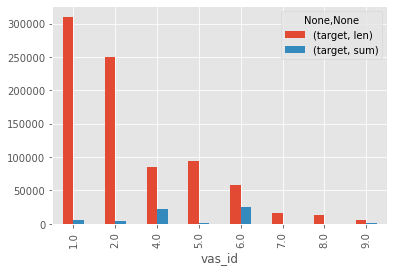

In [16]:
gg=data.groupby('vas_id').agg({'target':[len, sum]})
gg.plot(kind='bar')

In [17]:
gg.columns = ['len', 'sum']
gg['rt'] = gg['sum'] / gg['len']
gg

,len,sum,rt
vas_id,,,
1.0,310175.0,5664.0,0.018261
2.0,249505.0,4797.0,0.019226
4.0,85756.0,21765.0,0.253801
5.0,94085.0,1692.0,0.017984
6.0,57878.0,24704.0,0.426829
7.0,15432.0,213.0,0.013802
8.0,13350.0,347.0,0.025993
9.0,5472.0,1004.0,0.183480


### 1.2 Разделяем на train и test

In [18]:
# Разделим признаки и целевую переменную
#data_prelim = data[data['vas_id'].isin([9])] #.copy()
data_prelim = data.copy()

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0%


0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

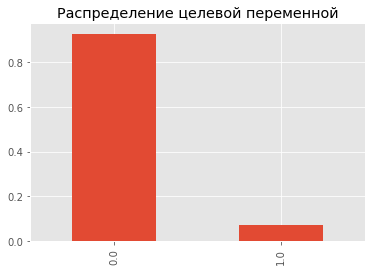

In [19]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [20]:
# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 888

train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print(y.loc[train_idx].value_counts())
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0.0    0.927521
1.0    0.072479
Name: target, dtype: float64

0.0    578531
1.0     45208
Name: target, dtype: int64

Test
0.0    0.927961
1.0    0.072039
Name: target, dtype: float64


In [21]:
X_train, y_train = balanced_positive(X_train, y_train)

0.0    0.516072
1.0    0.483928
Name: target, dtype: float64

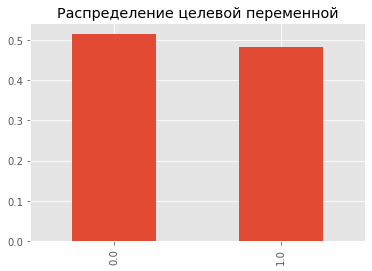

In [22]:
(y_train.value_counts()/y_train.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y_train.value_counts()/y_train.shape

# 2 Определение типа признаков

In [23]:
X_nunique = X_train.apply(lambda x: x.nunique(dropna=False))
X_nunique.shape

(259,)

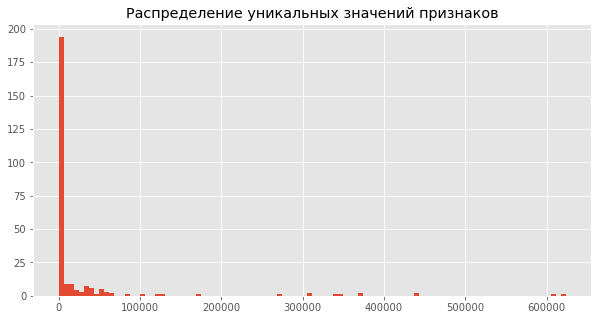

In [24]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [25]:
f_const, f_categorical, f_numeric = divide_features(X_train, ['Unnamed: 0', 'lag', 'id', 'feat_time', 'vas_id', 'buy_time'], N_cat=15)

print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))


f_all: 259

f_const: 5
f_categorical: 35
f_numeric: 212


# 3 Pipeline для baseline модели

In [26]:
fc_baseline = FeatureCollection()
fc_baseline.set_categorical(X_train,f_categorical+['vas_id'])
fc_baseline.set_features('nmb',f_numeric)
fc_baseline.set_features('month', ['buy_time'])

In [27]:
%%time

bl_estimator, X_test_feats, y_test_pred = model_report(fc_baseline, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         0.0     0.9825    0.8697    0.9227    192936
         1.0     0.3229    0.8002    0.4602     14978

    accuracy                         0.8647    207914
   macro avg     0.6527    0.8350    0.6914    207914
weighted avg     0.9350    0.8647    0.8894    207914

Wall time: 3min 26s


0.6914

## 3.1 Отберем категориальные и числовые признаки 

In [28]:
%%time
#Для отбора признаков обучим логистическую модель с регуляризацией L1
bl_estimator, X_test_feats, y_test_pred = model_report(fc_baseline, X_train, y_train, X_test, y_test, C=0.005)

              precision    recall  f1-score   support

         0.0     0.9825    0.8697    0.9227    192936
         1.0     0.3229    0.8002    0.4602     14978

    accuracy                         0.8647    207914
   macro avg     0.6527    0.8350    0.6914    207914
weighted avg     0.9350    0.8647    0.8894    207914

Wall time: 2min 48s


In [29]:
#Выделим незначащие колонки
f_exclude = select_columns(bl_estimator['log_reg'], X_test_feats)
print(f'remove {len(f_exclude)} features')
#Удалим незначащие колонки из колекции признаков
fc_baseline_select = fc_baseline.copy().remove(f_exclude)

remove 110 features


In [30]:
%%time
#Проверим качество модели
bl_estimator, X_test_feats, y_test_pred = model_report(fc_baseline_select, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         0.0     0.9825    0.8697    0.9227    192936
         1.0     0.3228    0.8003    0.4601     14978

    accuracy                         0.8647    207914
   macro avg     0.6527    0.8350    0.6914    207914
weighted avg     0.9350    0.8647    0.8893    207914

Wall time: 2min 41s


6 = 0.6915

# 4. Генерация и отбор новых принаков

## 4.1 Добавим квадраты числовых признаков

In [31]:
fc_pol2 = fc_baseline_select.copy()
fc_pol2.set_features('pol2', f_numeric)

In [32]:
%%time
#Для отбора признаков обучим логистическую модель с регуляризацией L1
bl_estimator, X_test_feats, y_test_pred = model_report(fc_pol2, X_train, y_train, X_test, y_test, C=0.005)

              precision    recall  f1-score   support

         0.0     0.9731    0.9133    0.9423    192936
         1.0     0.3766    0.6743    0.4833     14978

    accuracy                         0.8961    207914
   macro avg     0.6748    0.7938    0.7128    207914
weighted avg     0.9301    0.8961    0.9092    207914

Wall time: 4min 29s


0.7121

In [33]:
#Выделим незначащие колонки
f_exclude = select_columns(bl_estimator['log_reg'], X_test_feats)
print(f'remove {len(f_exclude)} features')
#Удалим незначащие колонки из колекции признаков
fc_pol2_select = fc_pol2.copy().remove(f_exclude)

remove 50 features


In [34]:
%%time
#Проверим качество модели
bl_estimator, X_test_feats, y_test_pred = model_report(fc_pol2_select, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         0.0     0.9730    0.9136    0.9424    192936
         1.0     0.3771    0.6739    0.4836     14978

    accuracy                         0.8963    207914
   macro avg     0.6751    0.7937    0.7130    207914
weighted avg     0.9301    0.8963    0.9093    207914

Wall time: 4min 38s


0.7104 <br>



# 5 Финальная модель

In [35]:
fc_fin = fc_pol2_select.copy()

In [36]:
from sklearn.ensemble import RandomForestClassifier

transf = fc_fin.make_pipeline()
estimator = Pipeline([
                ('estimator', RandomForestClassifier(max_depth=3, random_state=RANDOM_STATE, n_jobs=-1)),
                ])
estimator.fit(transf.fit_transform(X_train, y_train), y_train)
X_test_transf = transf.transform(X_test)
y_pred = estimator.predict_proba(X_test_transf )[:,1]
print(classification_report(y_test, y_pred > 0.5, digits=4))

              precision    recall  f1-score   support

         0.0     0.9791    0.8834    0.9288    192936
         1.0     0.3352    0.7576    0.4648     14978

    accuracy                         0.8743    207914
   macro avg     0.6572    0.8205    0.6968    207914
weighted avg     0.9328    0.8743    0.8954    207914



max_depth=5 0.6937 <br>
max_depth=7 0.6893 <br>

In [37]:
import xgboost as xgb

transf = fc_fin.make_pipeline()
estimator = Pipeline([
                ('estimator', xgb.XGBClassifier(random_state=21, max_depth=3,)),
                ])
estimator.fit(transf.fit_transform(X_train, y_train), y_train)
X_test_transf = transf.transform(X_test)
y_pred = estimator.predict_proba(X_test_transf )[:,1]
print(classification_report(y_test, y_pred > 0.5, digits=4))

[18:08:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0     0.9919    0.8206    0.8982    192936
         1.0     0.2833    0.9134    0.4325     14978

    accuracy                         0.8273    207914
   macro avg     0.6376    0.8670    0.6653    207914
weighted avg     0.9408    0.8273    0.8646    207914



In [40]:
fn_estimator = Pipeline([
    ('transform', fc_fin.make_pipeline()),
    ('log_reg', LogisticRegression(C=1, penalty='l1', solver='saga', random_state=RANDOM_STATE, n_jobs=-1, tol=0.001)),
])

In [41]:
%%time

fn_estimator.fit(X_train, y_train)
y_pred = fn_estimator.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred > 0.5, digits=4))

              precision    recall  f1-score   support

         0.0     0.9730    0.9136    0.9424    192936
         1.0     0.3771    0.6739    0.4836     14978

    accuracy                         0.8963    207914
   macro avg     0.6751    0.7937    0.7130    207914
weighted avg     0.9301    0.8963    0.9093    207914

Wall time: 4min 40s


## Сохраняем модель

In [42]:
import joblib

In [43]:
joblib.dump(fn_estimator, "log_reg_model3.pkl")

['log_reg_model3.pkl']

In [ ]:
#fn_estimator = joblib.load("model.pkl")